# Introduction

Author: Austin Dibble

This notebook file was used to compare the performance of different trained versions of the model architectures.

# Import code and dataset

In [1]:
!git clone https://github.com/Dibz15/OpenMineChangeDetection.git
import sys
sys.path.append('/content/OpenMineChangeDetection/')

fatal: destination path 'OpenMineChangeDetection' already exists and is not an empty directory.


In [ ]:
from OpenMineChangeDetection.utils import download_prep_oms2cd
download_prep_oms2cd(output_dir='OMS2CD')

# Install dependences

In [2]:
%%capture
!pip install rasterio==1.3.8
!pip install torchgeo==0.4.1
!pip install tiler==0.5.7
!pip install kornia==0.6.12
!pip install lightning==1.9.5
!pip install torchmetrics==0.11.4

# Seed random, set device

In [2]:
import os
import torch
import random
import numpy as np

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

torch.manual_seed(543)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(543)
random.seed(543)
np.random.seed(543)

# Prepare dataloader

In [3]:
from OpenMineChangeDetection.datasets import OMS2CDDataModule
from torchgeo.transforms import AugmentationSequential
import kornia.augmentation as K
from OpenMineChangeDetection.ddpm_cd.ddpm_lightning import CD

datamodule = OMS2CDDataModule(root='OMS2CD', bands='rgb', load_area_mask=False,
                              batch_size=1, tile_mode="constant", index_no_mask=False, stride=100)
datamodule.setup('fit')
datamodule.setup('validate')
datamodule.setup('test')

# Define model loading functions

In [8]:


def get_mask_preds_ddpmcd(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch = datamodule.aug(batch)

    mask_pred = model(batch)
    # mask_pred = torch.argmax(mask_pred, dim=1, keepdim=False)
    mask_pred_prob = torch.softmax(mask_pred, dim=1)
    # mask_pred_val, mask_pred_idx = torch.max(mask_pred, 1)
    mask_pred_prob_class1 = mask_pred_prob[:, 1, :, :]
    return mask_pred_prob_class1, batch['mask']

In [12]:
def get_mask_preds_tinycd(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch = datamodule.aug(batch)
    mask_pred = model(batch['image']).squeeze(1)
    mask_target = batch['mask']
    return mask_pred, mask_target

def get_mask_preds_lsnet(model, batch, device):
    batch = {k: v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
    batch = datamodule.aug(batch)
    mask_pred = model(batch)
    mask_pred = mask_pred[-1]
    mask_pred_prob = torch.softmax(mask_pred, dim=1)
    # mask_pred_val, mask_pred_idx = torch.max(mask_pred, 1)
    mask_pred_prob_class1 = mask_pred_prob[:, 1, :, :]
    return mask_pred_prob_class1, batch['mask']

In [10]:
import matplotlib.pyplot as plt
from OpenMineChangeDetection.utils import load_tinycd, load_lsnet, load_ddpmcd, load_ddpmcd_oms2cd
from OpenMineChangeDetection.utils import evaluate_model, plot_pr_curve

def plot_masks(output, target, threshold):
    # Convert tensors to numpy arrays
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    # Threshold output to create binary mask
    output = output > threshold

    # Select the first image
    output_img = output[0]
    target_img = target[0]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the output mask in the first subplot
    axs[0].imshow(output_img, cmap='gray')
    axs[0].set_title('Output')

    # Plot the target mask in the second subplot
    axs[1].imshow(target_img, cmap='gray')
    axs[1].set_title('Target')

    # Remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Define testing functions

In [12]:
import os
import pandas as pd
import torch
import torchmetrics
from tqdm import tqdm

def test_model_dir(weights_dir, load_model_func, proc_func, dataloader, device, threshold=0.3):
    # Initialize an empty DataFrame to store the stats
    stats_list = []
    for filename in os.listdir(weights_dir):
        if filename.endswith('.pt') or filename.endswith('.pth'):
            p = os.path.join(weights_dir, filename)
            print(f'Loading model from {p} and evaluating.')
            model = load_model_func(p, device)
            stats = evaluate_model(model, dataloader, proc_func, device, threshold)
            stats['weights_file'] = filename
            del stats['PRC']
            stats_list.append(stats)
            # break
    df = pd.DataFrame(stats_list)
    # Sort the DataFrame by F1 score in descending order
    df = df.sort_values('F1', ascending=False)
    return df

def test_model_dir_recursive(weights_dir, load_model_func, proc_func, dataloader, device, threshold=0.3):
    # Initialize an empty DataFrame to store the stats
    stats_list = []

    # Use os.walk to recursively search for .ckpt files
    for root, _, files in os.walk(weights_dir):
        for filename in sorted(files):
            if filename.endswith('.ckpt'):
                # Get the full path to the file
                filepath = os.path.join(root, filename)
                print(f'Loading model from {filepath} and evaluating.')

                model = load_model_func(filepath, device)
                stats = evaluate_model(model, dataloader, proc_func, device, threshold)
                stats['weights_path'] = filepath
                del stats['PRC']

                stats_list.append(stats)

    # Convert the list of stats to a DataFrame
    df = pd.DataFrame(stats_list)

    # Sort the DataFrame by F1 score in descending order
    df = df.sort_values('F1', ascending=False)

    return df

# Test DDPM-CD

In [18]:
# Val mask areas only
stats_df = test_model_dir_recursive('.',
                          load_ddpmcd, get_mask_preds_ddpmcd, datamodule.val_dataloader(),
                          device, threshold=0.3)

Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/cd_model_epoch=31-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:09<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/cd_model_epoch=13-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=18-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=21-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:09<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_161457/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=28-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:09<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=34-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/cd_model_ft_epoch=10-val_loss=0.06.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:10<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:12<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=14-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:11<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=18-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:12<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:12<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/cd_model_ft_epoch=8-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:11<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:11<00:00,  1.06it/s]


Loading model from ./checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 203/203 [03:12<00:00,  1.06it/s]


In [25]:
print(stats_df.head(100))
for path in stats_df['weights_path']:
    print(path)

          OA        F1    recall  precision        AP       IoU  \
0   0.976022  0.643132  0.696230   0.597560  0.678367  0.360586   
12  0.978290  0.638660  0.618243   0.660471  0.683351  0.347618   
6   0.978204  0.629387  0.596377   0.666267  0.681739  0.352659   
5   0.972377  0.626494  0.746496   0.539731  0.669957  0.352664   
4   0.976186  0.618575  0.622223   0.614970  0.659356  0.340002   
8   0.974628  0.614198  0.650791   0.581501  0.637438  0.341487   
2   0.973570  0.606327  0.655866   0.563747  0.628947  0.330890   
17  0.977762  0.603603  0.545580   0.675436  0.659877  0.315193   
9   0.975544  0.602144  0.596352   0.608049  0.623208  0.325130   
1   0.975718  0.597023  0.579611   0.615515  0.633814  0.328054   
13  0.978032  0.588476  0.506134   0.702817  0.668155  0.319203   
14  0.977065  0.586147  0.523350   0.666068  0.624850  0.308785   
10  0.976195  0.576366  0.521817   0.643652  0.630044  0.308024   
3   0.969869  0.576167  0.659947   0.511262  0.594375  0.32624

In [26]:
# Test mask areas only
stats_df = test_model_dir_recursive('.',
                          load_ddpmcd, get_mask_preds_ddpmcd, datamodule.test_dataloader(),
                          device, threshold=0.3)

Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/cd_model_epoch=31-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/cd_model_epoch=13-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=18-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=21-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_161457/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=28-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=34-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/cd_model_ft_epoch=10-val_loss=0.06.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:01<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=14-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=18-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:01<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/cd_model_ft_epoch=8-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [04:00<00:00,  1.06it/s]


Loading model from ./checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [03:59<00:00,  1.07it/s]


In [27]:
print(stats_df.head(100))
for path in stats_df['weights_path']:
    print(path)

          OA        F1    recall  precision        AP       IoU  \
4   0.967752  0.331073  0.332188   0.329966  0.277436  0.162674   
5   0.956165  0.327105  0.443491   0.259108  0.275348  0.175451   
13  0.973628  0.325668  0.265073   0.422175  0.305308  0.155937   
0   0.956841  0.320534  0.423747   0.257753  0.258192  0.170193   
12  0.958577  0.320068  0.405828   0.264230  0.266118  0.173040   
14  0.972519  0.297700  0.242444   0.385578  0.262847  0.123013   
2   0.963158  0.297376  0.324528   0.274416  0.224376  0.145646   
6   0.965793  0.295407  0.298487   0.292391  0.239171  0.147090   
3   0.960512  0.294432  0.342955   0.257937  0.220861  0.149109   
11  0.962592  0.290353  0.318545   0.266746  0.234634  0.141572   
9   0.949593  0.285099  0.418374   0.216221  0.205507  0.151686   
8   0.952677  0.283304  0.389334   0.222665  0.211611  0.156831   
1   0.960391  0.282088  0.323921   0.249824  0.209049  0.136311   
10  0.971291  0.280412  0.232842   0.352410  0.237481  0.13678

In [13]:

datamodule = OMS2CDDataModule(root='OMS2CD', bands='rgb', load_area_mask=False,
                              batch_size=1, tile_mode="constant", index_no_mask=True, stride=100)
datamodule.setup('fit')
datamodule.setup('validation')
datamodule.setup('test')

In [29]:
# Val all areas
stats_df = test_model_dir_recursive('.',
                          load_ddpmcd, get_mask_preds_ddpmcd, datamodule.val_dataloader(),
                          device, threshold=0.3)

Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/cd_model_epoch=31-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:16<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:16<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/cd_model_epoch=13-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:15<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:14<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=18-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:16<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=21-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:15<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_161457/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:15<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=28-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=34-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:16<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/cd_model_ft_epoch=10-val_loss=0.06.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:14<00:00,  1.07it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=14-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=18-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:14<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/cd_model_ft_epoch=8-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:17<00:00,  1.06it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:14<00:00,  1.07it/s]


Loading model from ./checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 463/463 [07:18<00:00,  1.06it/s]


In [30]:
print(stats_df.head(100))
for path in stats_df['weights_path']:
    print(path)

          OA        F1    recall  precision        AP       IoU  \
0   0.988461  0.621461  0.696116   0.561267  0.652744  0.381342   
12  0.989688  0.619313  0.616487   0.622164  0.650248  0.450914   
6   0.990018  0.618477  0.594652   0.644291  0.656321  0.508105   
5   0.986821  0.606581  0.746673   0.510753  0.655944  0.418034   
4   0.988906  0.603980  0.621770   0.587179  0.632762  0.429826   
8   0.988179  0.600686  0.653424   0.555824  0.618443  0.470282   
17  0.989959  0.596178  0.544716   0.658380  0.640922  0.531926   
2   0.987664  0.589779  0.651721   0.538590  0.607440  0.465170   
1   0.988884  0.586127  0.578489   0.593969  0.610580  0.459496   
9   0.988461  0.585170  0.598150   0.572742  0.592973  0.450504   
13  0.990077  0.579498  0.502523   0.684322  0.646817  0.502630   
14  0.989713  0.578749  0.519359   0.653476  0.610355  0.555021   
15  0.986963  0.566097  0.625013   0.517332  0.582507  0.481971   
10  0.989080  0.564954  0.521083   0.616891  0.602960  0.47224

In [14]:
# Test all areas
stats_df = test_model_dir_recursive('.',
                          load_ddpmcd, get_mask_preds_ddpmcd, datamodule.test_dataloader(),
                          device, threshold=0.3)

Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/cd_model_epoch=31-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_192507/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:45<00:00,  1.52it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/cd_model_epoch=13-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230715_130727/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=18-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/cd_model_ft_epoch=21-val_loss=0.05.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_213446/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:46<00:00,  1.51it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_161457/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:46<00:00,  1.51it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=28-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.51it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230716_173018/checkpoint/cd_model_ft_epoch=34-val_loss=0.03.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/cd_model_ft_epoch=10-val_loss=0.06.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_161842/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=14-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/cd_model_ft_epoch=18-val_loss=0.02.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230718_183929/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:48<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/cd_model_ft_epoch=8-val_loss=0.04.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./experiments/ddpm-RS-CDHead-OMS2CD_230717_103144/checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


Loading model from ./checkpoint/last.ckpt and evaluating.
Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 342/342 [03:47<00:00,  1.50it/s]


In [15]:
print(stats_df.head(100))
for path in stats_df['weights_path']:
    print(path)

          OA        F1    recall  precision        AP       IoU  \
13  0.975528  0.277062  0.261795   0.294221  0.232172  0.119554   
4   0.967252  0.264459  0.328661   0.221241  0.196513  0.126627   
5   0.954244  0.258069  0.444258   0.181853  0.202095  0.133165   
14  0.974589  0.254379  0.241986   0.268109  0.197839  0.135466   
12  0.957373  0.253372  0.403791   0.184604  0.198096  0.128875   
0   0.951069  0.236754  0.423670   0.164277  0.180329  0.140284   
6   0.964908  0.235650  0.301994   0.193206  0.164359  0.128695   
10  0.971782  0.227579  0.232068   0.223262  0.162203  0.113146   
2   0.959187  0.221338  0.323836   0.168125  0.146097  0.124360   
11  0.959143  0.217659  0.317290   0.165645  0.157561  0.115677   
1   0.957298  0.215488  0.327408   0.160592  0.142356  0.121206   
3   0.954741  0.212348  0.340592   0.154263  0.136862  0.125116   
8   0.947806  0.209533  0.386193   0.143768  0.137667  0.120392   
9   0.943003  0.208648  0.419478   0.138858  0.129206  0.12216

# PR curve example

In [5]:
from OpenMineChangeDetection.utils import load_tinycd_oms2cd, load_lsnet_oms2cd, load_ddpmcd_oms2cd
from OpenMineChangeDetection.utils import get_mask_preds_lsnet, get_mask_preds_tinycd, get_mask_preds_ddpmcd, evaluate_model, plot_pr_curve

lsnet = load_lsnet_oms2cd(device)
tinycd = load_tinycd_oms2cd(device)
ddpmcd = load_ddpmcd_oms2cd(device)

export CUDA_VISIBLE_DEVICES=0


INFO:base:Initialization method [orthogonal]
INFO:base:Initialization method [orthogonal]


Loading CD gen state dict from diffusion_weights/best_cd_model_gen.pth.


INFO:base:Initialization method [orthogonal]


Loading DDPM gen state dict from diffusion_weights/I190000_E97_gen.pth


100%|██████████| 255/255 [00:09<00:00, 26.81it/s]


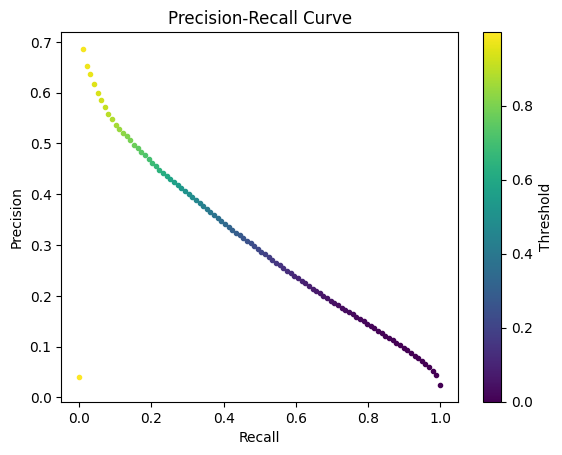

In [15]:
datamodule.setup('test')
stats = evaluate_model(tinycd.to(device).eval(), datamodule.test_dataloader(), get_mask_preds_tinycd, device, threshold=0.30, pr_thresholds=None)
plot_pr_curve(stats['PRC'])

100%|██████████| 255/255 [00:10<00:00, 23.27it/s]


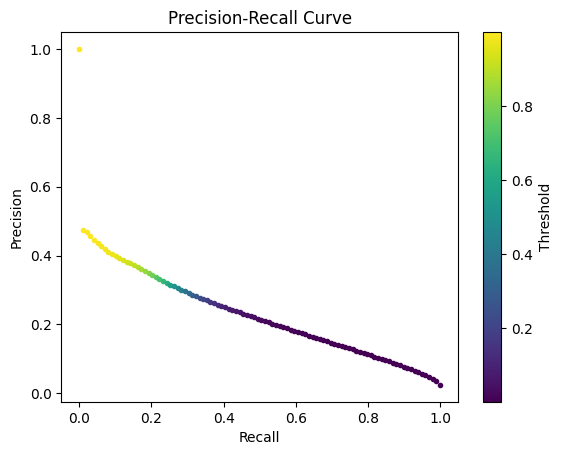

In [16]:
stats = evaluate_model(lsnet.to(device).eval(), datamodule.test_dataloader(), get_mask_preds_lsnet, device, threshold=0.30, pr_thresholds=None)
plot_pr_curve(stats['PRC'])

100%|██████████| 255/255 [01:55<00:00,  2.21it/s]


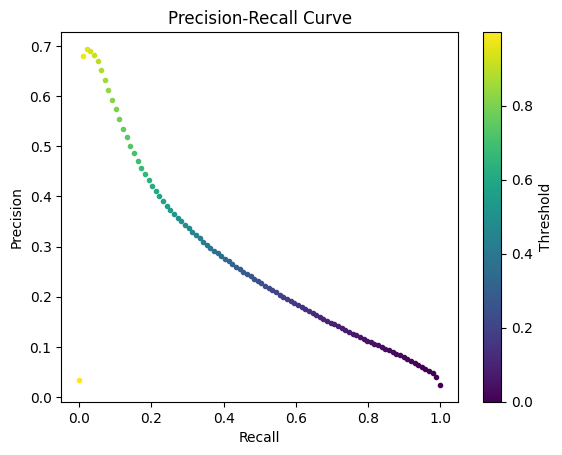

In [17]:
stats = evaluate_model(ddpmcd.to(device).eval(), datamodule.test_dataloader(), get_mask_preds_ddpmcd, device, threshold=0.30, pr_thresholds=None)
plot_pr_curve(stats['PRC'])